# Accessing higher energy states with Qiskit Pulse

We begin by importing dependencies and defining some default variable values. We choose qubit 0 to run our experiments. We perform our experiments on the publicly available single qubit device `ibmq_armonk`.

In [59]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform
from qiskit.tools.monitor import job_monitor
from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit.test.mock import FakeValencia

In [3]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
#IBMQ.load_account()
#IBMQ.active_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Qubit 0 has an estimated frequency of 4.971648972721859 GHz.


We define some additional helper functions.

In [4]:
def get_job_data(job, average, qubit):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

Next we include some default parameters for drive pulses and measurement. We pull the `measure` command from the instruction schedule map (from backend defaults), so that it is updated with new calibrations.

In [5]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

In [6]:
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [7]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

## 1. Discriminating the $|0\rangle$ and $|1\rangle$ states <a id="discrim01"></a>

In this section, we build a discriminator for our standard $|0\rangle$ and $|1\rangle$ states. The job of the discriminator is to take `meas_level=1` complex data and classify it into the standard $|0\rangle$ and $|1\rangle$ states (`meas_level=2`). This will replicate much of the work of the prior [chapter](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html). These results are necessary for exciting the higher energy states which are the focus of this notebook.

### 1A. 0->1 Frequency Sweep  <a id="freqsweep01"></a>

The first step in building a discriminator is to calibrate our qubit frequency, as done in the prior chapter.

In [8]:
def create_ground_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the ground state. 
    Depending on drive power this can reveal the 0->1 frequency or the 0->2 frequency. 
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Raised if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try to do this.
    Returns:
        Qobj: Program for ground freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    
    schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
    schedule |= measure << schedule.duration
    
    # define frequencies for the sweep
    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble the program
    # Note: we only require a single schedule since each does the same thing;
    # for each schedule, the LO frequency that mixes down the drive changes
    # this enables our frequency sweep
    ground_freq_sweep_program = assemble(schedule,
                                         backend=backend, 
                                         meas_level=1,
                                         meas_return='avg',
                                         shots=NUM_SHOTS,
                                         schedule_los=schedule_freqs)
    
    return ground_freq_sweep_program

In [9]:
# We will sweep 40 MHz around the estimated frequency, with 75 frequencies
num_freqs = 75
ground_sweep_freqs = default_qubit_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
ground_freq_sweep_program = create_ground_freq_sweep_program(ground_sweep_freqs, drive_power=0.1)

The frequency sweep will go from 4.951648972721859 GHz to 4.991648972721859 GHz using 75 frequencies. The drive power is 0.1.


In [10]:
#ground_freq_sweep_job=backend.retrieve_job('60b35e074e242774f62cd9e8')
ground_freq_sweep_job = backend.run(ground_freq_sweep_program)

In [11]:
print(ground_freq_sweep_job.job_id())
job_monitor(ground_freq_sweep_job)

60ffbbff3852d187d807ba80
Job Status: job has successfully run


In [12]:
# Get the job data (average)
ground_freq_sweep_data = get_job_data(ground_freq_sweep_job, average=True, qubit = qubit)

We fit our data to a Lorentzian curve and extract the calibrated frequency.

In [13]:
backend_defaults.qubit_freq_est

[4971648972.721859]

In [14]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [15]:
# do fit in Hz
freq_est = backend_defaults.qubit_freq_est[qubit]
(ground_sweep_fit_params, 
 ground_sweep_y_fit) = fit_function(ground_sweep_freqs,
                                   ground_freq_sweep_data, 
                                   lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                   [7, freq_est, 0.1*GHz, 3*GHz] # initial parameters for curve_fit 4.975
                                   )

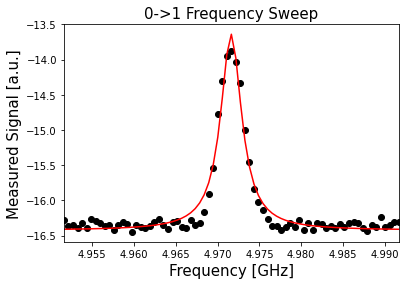

In [16]:
# Note: we are only plotting the real part of the signal
plt.scatter(ground_sweep_freqs/GHz, ground_freq_sweep_data, color='black')
plt.plot(ground_sweep_freqs/GHz, ground_sweep_y_fit, color='red')
plt.xlim([min(ground_sweep_freqs/GHz), max(ground_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->1 Frequency Sweep", fontsize=15)
plt.show()

In [17]:
_, cal_qubit_freq, _, _ = ground_sweep_fit_params
print(f"We've updated our qubit frequency estimate from "
      f"{round(default_qubit_freq/GHz, 7)} GHz to {round(cal_qubit_freq/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 4.971649 GHz to 4.9716229 GHz.


In [58]:
cal_qubit_freq

4971622852.231418

### 1B. 0->1 Rabi Experiment <a id="rabi01"></a>

Next, we perform a Rabi experiment to compute the $0\rightarrow1 ~ \pi$ pulse amplitude. Recall, a $\pi$ pulse is a pulse that takes us from the $|0\rangle$ to $|1\rangle$ state (a $\pi$ rotation on the Bloch sphere).

In [18]:
# experimental configuration
num_rabi_points = 50 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [19]:
# Create schedule
rabi_01_schedules = []
# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_01_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=drive_amp, 
                                       sigma=drive_sigma, 
                                       name='rabi_01_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(rabi_01_pulse, drive_chan)
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    rabi_01_schedules.append(schedule)

In [20]:
# Assemble the schedules into a program
# Note: We drive at the calibrated frequency.
rabi_01_expt_program = assemble(rabi_01_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [21]:
rabi_01_job = backend.run(rabi_01_expt_program)

In [22]:
print(rabi_01_job.job_id())
job_monitor(rabi_01_job)

60ffbc8ea0da18df60f52588
Job Status: job has successfully run


In [23]:
# Get the job data (average)
rabi_01_data = get_job_data(rabi_01_job, average=True, qubit=qubit)

In [24]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

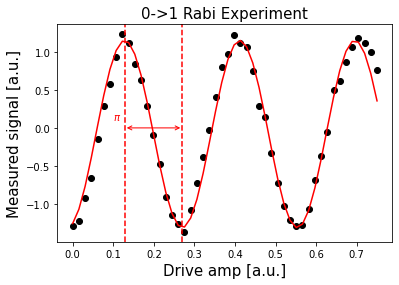

In [43]:
# Note: Only real part of data is plotted
rabi_01_data = np.real(baseline_remove(rabi_01_data))
(rabi_01_fit_params, 
 rabi_01_y_fit) = fit_function(drive_amps,
                               rabi_01_data, 
                               lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*x/drive_01_period - phi) + B),
                               [4, 0.1, 0.3, 0]) # original value was [4, -4, 0.5, 0]

plt.scatter(drive_amps, rabi_01_data, color='black')
plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2] 
# account for phi in computing pi amp
pi_amp_01 = (drive_01_period/2/np.pi) *(np.pi+rabi_01_fit_params[3])

plt.axvline(pi_amp_01, color='red', linestyle='--')
plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('0->1 Rabi Experiment', fontsize=15)
plt.show()

In [26]:
print(f"Pi Amplitude (0->1) = {pi_amp_01}")

Pi Amplitude (0->1) = 0.1283062596553004


Using these results, we define our $0\rightarrow1$ $\pi$ pulse.

In [27]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

# Constructing X gate

In [34]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)

circ.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

In [35]:
from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit.test.mock import FakeValencia

backend = FakeValencia()

#with pulse.build(backend, name='hadamard') as h_q0:
#    pulse.play(Gaussian(duration=128, amp=0.1, sigma=16), pulse.drive_channel(0))

with pulse.build(backend, name='x_01') as x_01:
    pulse.play(pi_pulse_01, pulse.drive_channel(0))

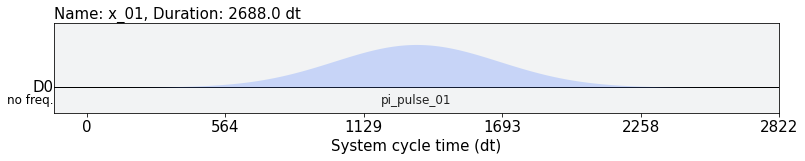

In [36]:
x_01.draw()

In [37]:
circ.add_calibration('x', [0], x_01)

In [38]:
from qiskit import transpile
from qiskit.test.mock import FakeAlmaden

backend = FakeAlmaden()

circ = QuantumCircuit(2, 2)
circ = transpile(circ, backend)

print(backend.configuration().basis_gates)
circ.draw(idle_wires=False)

['id', 'u1', 'u2', 'u3', 'cx']


In [39]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

circ = QuantumCircuit(1, 1)
pulse_x_gate = Gate('pulse_x_gate', 1,[])
circ.append(pulse_x_gate, [0])
circ.measure(0, 0)

circ.draw()

┌──────────────┐┌─┐
q_0: ┤ pulse_x_gate ├┤M├
     └──────────────┘└╥┘
c: 1/═════════════════╩═
                      0

In [40]:
with pulse.build(backend, name='pulse_x') as pulse_x_schedule:
    pulse.play(pi_pulse_01, pulse.drive_channel(0))

circ.add_calibration('pulse_x_gate', [0], pulse_x_schedule)

In [41]:
circ = transpile(circ, backend)
circ.draw(idle_wires=False)

┌──────────────┐┌─┐
q_0 -> 0 ┤ pulse_x_gate ├┤M├
         └──────────────┘└╥┘
    c: 1/═════════════════╩═
                          0

In [44]:
circ.draw(idle_wires=False)

┌──────────────┐┌─┐
q_0 -> 0 ┤ pulse_x_gate ├┤M├
         └──────────────┘└╥┘
    c: 1/═════════════════╩═
                          0

In [ ]:
# IQ_012_program = assemble(schedule,
#                            backend=backend,
#                            meas_level=1,
#                            meas_return='single',
#                            shots=1024,
#                            schedule_los=[{drive_chan: qubit_01_freq_cal}] * 3)

# IQ_012_job = backend.run(IQ_012_program)
# job_monitor(IQ_012_job)

# result = IQ_012_job.result()

# # Single shots result
# IQ_012_data = [result.get_memory(i)[:,0]*scale_factor for i in range(len(result.results))]